# 4-1. 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [1]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 948.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=ca6ebff78a1044c2c6d880512cfc5103e5b6266c36fb0079816e48b2ae622ef3
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [2]:
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

nltk.download('stopwords')

# 불필요한 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 라이브러리 버전 출력
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)


3.9.1
2.18.0
2.2.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

sunnysai12345/News_Summary
아래의 코드로 데이터를 다운로드할 수 있어요.

In [3]:
!python --version

Python 3.11.12


In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="./news_summary_more.csv")

data = pd.read_csv('./news_summary_more.csv', encoding='utf-8')


In [ ]:
data.sample(10)

,headlines,text
62847,300 iPhone X units worth â¹2.4 cr stolen off ...,Over 300 Apple iPhone X units worth about $370...
66418,"Not your fault if you're depressed, don't hide...","Actress Deepika Padukone, in an article she pe..."
55356,Video of teacher getting massaged by student s...,A video of a government school teacher getting...
59977,We have a danger of India becoming a digital c...,"Talking about the IT sector in India, former I..."
11504,Amazon India head booked after man orders phon...,"Amazon India's head Amit Agarwal, and three ot..."
43519,Irrfan Khan reveals he has 'Neuroendocrine Tum...,Actor Irrfan Khan took to Twitter to reveal th...
90661,NSA collected 15 cr phone records in 2016 desp...,The US National Security Agency collected over...
90300,I'm not dressing for you: Deepika on Met Gala ...,"Deepika Padukone, while reacting to the critic..."
77298,59 years since 1st ever North Pole expedition ...,"On August 3, 1958, the world's first nuclear-p..."
9687,Men shave UP youth's head for posting morphed ...,"Several men allegedly shaved a youth's head, b..."


In [ ]:
# 컬럼 이름 변경
data.rename(columns={'headlines': 'Summary', 'text': 'Text'}, inplace=True)

# 컬럼 순서 변경
data = data[['Text', 'Summary']]

In [ ]:
data.sample(10)

,Text,Summary
4832,"PM Narendra Modi, Vice President Venkaiah Naid...",PM Modi pays tribute to late PM Vajpayee on 94...
26946,Thai authorities have said it would take nearl...,Rescue of 1st group of boys inside Thai cave t...
91865,Commenting on rising protectionism in major ec...,"Where would Apple, IBM be without global talen..."
51798,The trailer of the upcoming film 'Dil Juunglee...,"Trailer of Taapsee, Saqib Saleem starrer 'Dil ..."
64082,A woman from Scotland was the only passenger o...,"Scottish author only flyer on flight, gets spe..."
1310,Actress Kangana Ranaut has responded to report...,Who saw that film? Kangana on similarity betwe...
36783,"Weightlifter Sanjita Chanu, who won India's se...",Sad I couldn't break CWG record: India's gold ...
66133,Technology giant Apple has been granted a pate...,Apple patents self-adjusting Apple Watch bands
33335,American rapper Kanye West revealed that he wi...,Kanye to use pic of late mother's surgeon as ...
58187,"Actress-model Pamela Anderson, while respondin...",Pamela refuses to apologise for blaming Weinst...


# Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [ ]:
# 전처리 functions
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))


# --- 데이터 전처리 함수 ---
def preprocess_text(text, remove_stopwords=True):
    """텍스트 데이터를 전처리합니다.

    Args:
        text (str): 전처리할 텍스트 데이터.
        remove_stopwords (bool): 불용어를 제거할지 여부. 기본값은 True.

    Returns:
        str: 전처리된 텍스트 데이터.
    """
    text = text.lower()  # 텍스트 소문자화
    text = BeautifulSoup(text, "lxml").text  # HTML 태그 제거
    text = re.sub(r'\([^)]*\)', '', text)  # 괄호로 닫힌 문자열 제거
    text = re.sub('"', '', text)  # 쌍따옴표 제거
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])  # 약어 정규화
    text = re.sub(r"'s\b", "", text)  # 소유격 제거
    text = re.sub("[^a-zA-Z]", " ", text)  # 영어 외 문자 공백으로 변환
    text = re.sub('[m]{2,}', 'mm', text)  # m이 3개 이상이면 2개로 변경

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in text.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in text.split() if len(word) > 1)
    return tokens

# --- 샘플 길이 분석 및 필터링 ---
def below_threshold_len(max_len, nested_list):
    """샘플 길이가 임계값 이하인 비율을 계산합니다.

    Args:
        max_len (int): 최대 길이.
        nested_list (list): 샘플 리스트.

    Returns:
        float: 임계값 이하인 샘플 비율.
    """
    ratio = sum(1 for s in nested_list if len(s.split()) <= max_len) / len(nested_list)
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {ratio}')
    return ratio




정규화 사전의 수:  120


In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))


print (data.isnull().sum ())

if data.isnull().values.any():
    # 빈 값을 Null 값으로 변환
    data.replace('', np.nan, inplace=True)
    data.dropna(axis=0, inplace=True)
    data = data.dropna()
    print(f"after data.isnull().values.any()")


# --- 데이터 전처리 적용 ---
data['Text'] = data['Text'].apply(lambda text: preprocess_text(text, remove_stopwords=True))
data['Summary'] = data['Summary'].apply(lambda summary: preprocess_text(summary, remove_stopwords=False))

# 텍스트와 요약 데이터의 길이 분포 확인
text_lengths = [len(s.split()) for s in data['Text']]
summary_lengths = [len(s.split()) for s in data['Summary']]


전체 샘플수 : 98360
Text       0
Summary    0
dtype: int64


텍스트 길이 통계:
  최소 길이: 1
  최대 길이: 60
  평균 길이: 35.10

요약 길이 통계:
  최소 길이: 1
  최대 길이: 16
  평균 길이: 9.30


<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:30: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-

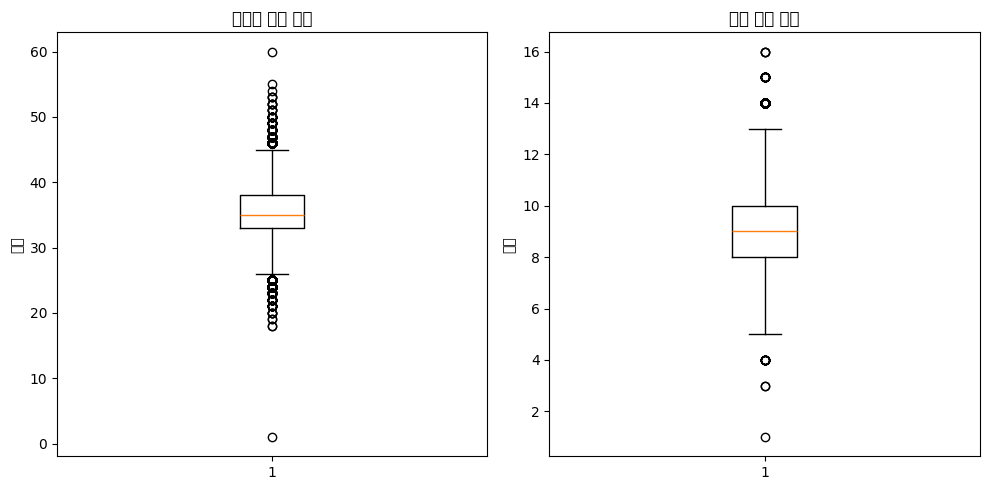

<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-108f6ee7563f>:47: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyth

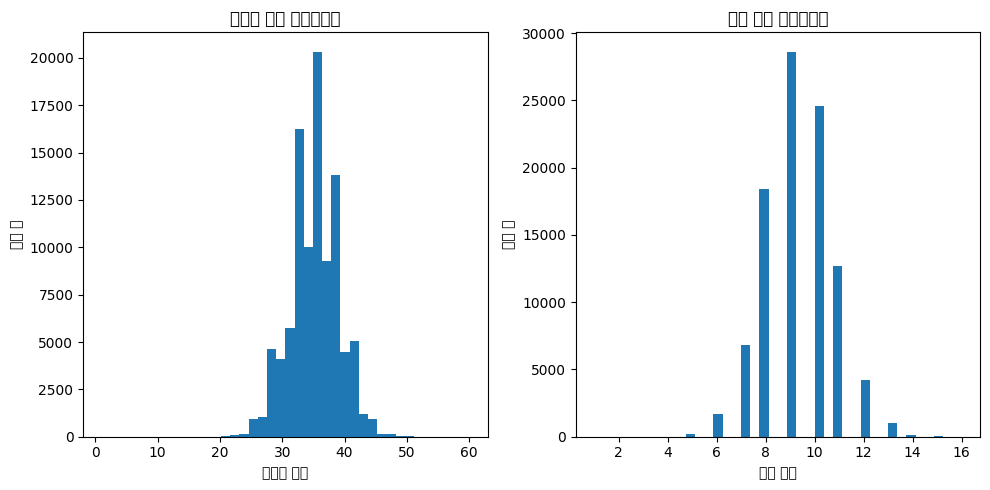

In [ ]:
def analyze_text_length(text_lengths, summary_lengths):
    """
    텍스트와 요약의 길이 통계량을 출력하고, 길이에 대한 박스 플롯과 히스토그램을 시각화합니다.

    Args:
        text_lengths (list): 텍스트 데이터의 길이 목록.
        summary_lengths (list): 요약 데이터의 길이 목록.
    """
    print('텍스트 길이 통계:')
    print(f'  최소 길이: {np.min(text_lengths)}')
    print(f'  최대 길이: {np.max(text_lengths)}')
    print(f'  평균 길이: {np.mean(text_lengths):.2f}') # 평균 길이는 소수점 2자리까지 표시
    print('\n요약 길이 통계:')
    print(f'  최소 길이: {np.min(summary_lengths)}')
    print(f'  최대 길이: {np.max(summary_lengths)}')
    print(f'  평균 길이: {np.mean(summary_lengths):.2f}') # 평균 길이는 소수점 2자리까지 표시

    # 박스 플롯 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.boxplot(text_lengths)
    plt.title('텍스트 길이 분포')
    plt.ylabel('길이')

    plt.subplot(1, 2, 2)
    plt.boxplot(summary_lengths)
    plt.title('요약 길이 분포')
    plt.ylabel('길이')

    plt.tight_layout()
    plt.show()

    # 히스토그램 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(text_lengths, bins=40)
    plt.title('텍스트 길이 히스토그램')
    plt.xlabel('텍스트 길이')
    plt.ylabel('샘플 수')

    plt.subplot(1, 2, 2)
    plt.hist(summary_lengths, bins=40)
    plt.title('요약 길이 히스토그램')
    plt.xlabel('요약 길이')
    plt.ylabel('샘플 수')

    plt.tight_layout()
    plt.show()

# 함수 호출
analyze_text_length(text_lengths, summary_lengths)

In [ ]:

# Text 35정도가 적당할까 싶긴 했지만 30-40 사이 -> 40
# Summary 도  9 할까 싶긴 했지만 8-10 사이 -> 10

# 최대 길이 설정
max_text_length = 40
max_summary_length = 10

# 임계값 이하인 샘플 비율 계산
below_threshold_len(max_text_length, data['Text'])
below_threshold_len(max_summary_length, data['Summary'])

# 조건에 맞는 샘플만 필터링
filtered_news_df = data[
    data['Text'].apply(lambda x: len(x.split()) <= max_text_length) &
    data['Summary'].apply(lambda x: len(x.split()) <= max_summary_length)
]


# 결과 출력
print(f"필터링 전 샘플 수: {len(data)}")
print(f"필터링 후 샘플 수: {len(filtered_news_df)}")

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687
필터링 전 샘플 수: 98360
필터링 후 샘플 수: 74102


In [ ]:
data.head()

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


In [ ]:
data.isnull().sum()

,0
Text,0
Summary,0


# 시작 토큰과 종료 토큰 추가하기

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [ ]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25030 38676 91819 ... 33633  3563  4466]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


# 데이터 전처리하기 (3) 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [ ]:
print(list(src_tokenizer.word_index.items())[:5])

[('said', 1), ('india', 2), ('year', 3), ('added', 4), ('us', 5)]


In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69552
등장 빈도가 6번 이하인 희귀 단어의 수: 47369
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22183
단어 집합에서 희귀 단어의 비율: 68.10587761674718
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.484682180457635


## 단어집합은 어떻게 할까??
22183이지만 크다고 무조건 좋지는 않을 것이라 단어가 얼마나 겹치는지 봐야하겠지만 일단 15000 선에서 성능보고 변경하면 좋을듯..

In [ ]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 15000 으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[185, 498, 2185, 6815, 1050, 614, 77, 3764, 91, 819, 353, 164, 756, 1340, 410, 7686, 1152, 410, 1106, 2007, 5937, 14741, 819, 91], [26, 38, 16, 2616, 3112, 291, 65, 2175, 80, 1157, 862, 2922, 725, 365, 2226, 3112, 71, 140, 3047, 672, 90, 7498, 1831, 65, 862, 2175, 268, 140, 183, 2424, 983, 448, 8697, 2995, 3408, 710, 312, 872], [95, 28, 18, 143, 17, 1325, 2234, 711, 2951, 2579, 204, 163, 389, 495, 1325, 3930, 6195, 115, 1032, 2784, 419, 3556, 1, 674, 5, 434, 2234, 4764, 2617, 1205, 1297, 10522]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30056
등장 빈도가 5번 이하인 희귀 단어의 수: 19616
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10440
단어 집합에서 희귀 단어의 비율: 65.26483896726111
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.630018063548155


# 단어집합 어게인

10440 아까와 같은 이유로 10000 보다는 조금 줄여서 8000 선에서 테스트

In [ ]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1030, 225, 849, 139, 141, 2251, 69, 276], [1, 513, 2113, 4, 19, 6, 2358, 26, 33, 109], [1, 1470, 1277, 3, 238, 144, 2321, 468, 7, 84, 337], [1, 786, 3, 377, 34, 3, 157, 477, 4, 1219], [1, 1253, 1791, 419, 2322, 5, 109, 485, 14, 8]]
target
decoder  [[1030, 225, 849, 139, 141, 2251, 69, 276, 2], [513, 2113, 4, 19, 6, 2358, 26, 33, 109, 2], [1470, 1277, 3, 238, 144, 2321, 468, 7, 84, 337, 2], [786, 3, 377, 34, 3, 157, 477, 4, 1219, 2], [1253, 1791, 419, 2322, 5, 109, 485, 14, 8, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


# 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [ ]:
# max_text_length = 40
# max_summary_length = 10

encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_length, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_length, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_summary_length, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_summary_length, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_summary_length, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_summary_length, padding='post')

In [ ]:
print("encoder_input_train: ", encoder_input_train, "\n", len(encoder_input_train), "개 (", len(encoder_input_train[0]), ")")
print("encoder_input_test: ", encoder_input_test, "\n", len(encoder_input_test), "개 (", len(encoder_input_test[0]), ")")
print("decoder_input_train: ", decoder_input_train, "\n", len(decoder_input_train), "개 (", len(decoder_input_train[0]), ")")
print("decoder_target_train: ", decoder_target_train, "\n", len(decoder_target_train), "개 (", len(decoder_target_train[0]), ")")
print("decoder_input_test: ", decoder_input_test, "\n", len(decoder_input_test), "개 (", len(decoder_input_test[0]), ")")
print("decoder_target_test: ", decoder_target_test, "\n", len(decoder_target_test), "개 (", len(decoder_target_test[0]), ")")

encoder_input_train:  [[ 185  498 2185 ...    0    0    0]
 [  26   38   16 ...  872    0    0]
 [  95   28   18 ...    0    0    0]
 ...
 [3085 3622 4209 ...    0    0    0]
 [ 161   20  325 ...    0    0    0]
 [ 129  367 9746 ...    0    0    0]] 
 78687 개 ( 40 )
encoder_input_test:  [[ 2089   339  4445 ...     0     0     0]
 [ 3604  9057  1073 ...     0     0     0]
 [  136   588  5105 ...     0     0     0]
 ...
 [  440    37  1064 ...     0     0     0]
 [ 1172   234 10740 ...     0     0     0]
 [ 6568  2561    69 ...     0     0     0]] 
 19672 개 ( 40 )
decoder_input_train:  [[   1 1030  225 ...   69  276    0]
 [   1  513 2113 ...   26   33  109]
 [1470 1277    3 ...    7   84  337]
 ...
 [   1   14 1550 ...   12  824  233]
 [   1   65   40 ...   15  240  359]
 [   1  154  372 ...  530 2922    0]] 
 78687 개 ( 10 )
decoder_target_train:  [[1030  225  849 ...  276    2    0]
 [ 513 2113    4 ...   33  109    2]
 [1277    3  238 ...   84  337    2]
 ...
 [  14 1550 3035 ...  824

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(max_text_length,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

encoder_outputs, state_h, state_c = encoder_output3, state_h3, state_c3

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 128)        │      1,920,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 40, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 128)      │      1,024,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 8000)     │      2,056,000 │ lstm_4[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,839,104 (26.09 MB)

 Trainable params: 6,839,104 (26.09 MB)

 Non-trainable params: 0 (0.00 B)

# 어텐션

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 128)        │      1,920,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 40, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 128)      │      1,024,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_4[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_4[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 8000)     │      4,104,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,887,360 (33.90 MB)

 Trainable params: 8,887,360 (33.90 MB)

 Non-trainable params: 0 (0.00 B)

# 모델 훈련

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# epochs = 5 택도 없음..
# epochs = 50 .. 여기까지도 두 로스는 꾸준히 줄어 들고 있다 .. 더 하는것도 가능할것 같지만 colab limit!!
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 63s 176ms/step - loss: 6.8265 - val_loss: 6.1768
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 79s 181ms/step - loss: 6.1702 - val_loss: 6.0663
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 58s 187ms/step - loss: 6.0853 - val_loss: 5.9842
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - loss: 5.9895 - val_loss: 5.9198
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - loss: 5.9175 - val_loss: 5.8564
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - loss: 5.7638 - val_loss: 5.6605
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 57s 185ms/step - loss: 5.6270 - val_loss: 5.5324
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - loss: 5.4752 - val_loss: 5.4168
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 81s 188ms/step - loss: 5.3397 - val_loss: 5.3180
Epoch 10/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 189ms/step - loss: 5.2341 - val_loss: 5.2223
Epoch 11/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - loss: 5.1282 - val_loss: 5.1369
Epoch 12/50
308/308

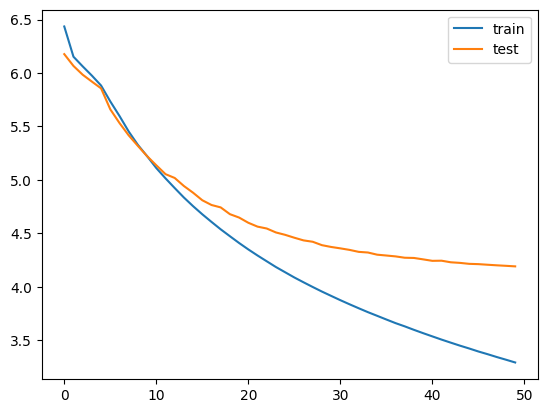

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
model.save("encoder_model.keras")
# model.save("encoder_model.h5")

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text_length, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
model.save("decoder_model.keras")

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_summary_length-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열 == Summary 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp += tar_index_to_word[i] + ' '  # 요약 단어 집합에서 정수 -> 단어 변환
    return temp.strip()

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, max_text_length)))
    print("\n")

원문 : google announced initiative youtube called method take users searching terrorism related violent extremist ideologies instead measure success method google analyse amount engagement counter terrorism content gets people
실제 요약 : seeking terror video takes youtube users to anti hate videos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
예측 요약 :  google users to delete to fight in russia


원문 : china monday supported claim india trespassing territory citing sikkim tibet treaty said india first pm jawaharlal nehru recognised however rejects nehru written treaty ladakh drawing line letter
실제 요약 : china quotes nehru on sikkim rejects other parts of letter
1/1

# Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

데이터 다운로드하기

예전에 사용했던 Avengers를 재탕해보았습니다.

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = requests.get('https://raw.githubusercontent.com/dev-ranger/sample_string/refs/heads/main/Avengers.txt').text

In [ ]:
print(text[:1500])

The Tesseract has awakened.
It is on a neutral world, a human world.
They wield its power,
but our ally knows it's working, so that they never will learn.
He's ready to lead, and our force, our Chitauri will follow.
The world will be his and the universe yours.
And the humans, what can they do, but burn.
How bad is it?
That's the problem, sir. We don't know.
Dr. Selvig read an energy surge from the Tesseract four hour ago.
NASA didn't authorize Selvig to pull the test phase.
He wasn't testing it, he wasn't even in the room. Spontaneous advancement
It just turned itself on?
What are the engine levels now?
Climbing. When Selvig couldn't shut it down, we ordered the evac.
How long to get everyone out?
Campus should be clear in the next half hour.
Do better.
Sir, evacuation maybe futile.
We should tell them to go back to sleep?
If we can't control the Tesseract's energy,
there may not be a minimum safe distance.
I need you to make sure that phase
Sir, is that really a priority right now?
U

summarize 사용하기

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
- I wanna know why Loki let us take him.
And I'd like to know how Loki used it to
You think you can make Loki tell us what the Tesseract is?
I'd like to know why SHIELD is using the Tesseract to build weapons of mass destruction.
I didn't need to know.
Loki's gonna keep this fight focused on us and that's what we need.
We got Stark up top, he's gonna need us...


In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['- I wanna know why Loki let us take him.', "And I'd like to know how Loki used it to", 'You think you can make Loki tell us what the Tesseract is?', "I'd like to know why SHIELD is using the Tesseract to build weapons of mass destruction.", "I didn't need to know.", "Loki's gonna keep this fight focused on us and that's what we need.", "We got Stark up top, he's gonna need us..."]


In [ ]:
print('Summary:')
print(summarize(text, words=50))

Summary:
- I wanna know why Loki let us take him.
And I'd like to know how Loki used it to
You think you can make Loki tell us what the Tesseract is?
I didn't need to know.
We got Stark up top, he's gonna need us...


정리:
딱히 똑똑하게 잘 정리하는 것 같지는 않지만..
그래도 자연어를 위한 전처리,인코딩, 디코딩 및 언어모델 사용해서 서버리도 해보고 좋은 경험이였습니다.
퍼실님들 말씀대로 마음을 비우고 딱히 기대감이 없으면 배우는게 많은 느낌입니다.